In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

CLEAN_PATH = "/home/yifan/experiments/noise/20/experiment1"
CONFIG_PATH = "/home/yifan/experiments/noise/20"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cpu'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CONFIG_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,1.0,0.3,0.05)


from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 489.09it/s]


NET resnet18
Finish initialization...


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [10]:

####### generate boundary ponits for tar and ref respectively
from AlignVis.AlignmentBoundaryGenerator import AlignmentBoundaryGenerator
BoundaryGen = AlignmentBoundaryGenerator(REF_PATH,REF_PATH,CLEAN_PATH,CONFIG_PATH,REF_EPOCH,TAR_EPOCH,DEVICE)
ref_boundary,tar_boundary = BoundaryGen.get_boundary_point(DEVICE,num_adv_eg=5000)
import torch
###### get border sample features
import torch.nn as nn

ref_feature_model = ref_model.to(DEVICE)
ref_feature_model = nn.Sequential(*list(ref_feature_model.children())[:-1])
with torch.no_grad():
    features = ref_feature_model(ref_boundary)
    ref_features = features.view(ref_boundary.shape[0], -1).cpu().numpy()

###### get border sample features
tar_feature_model = tar_model.to(DEVICE)
tar_feature_model = nn.Sequential(*list(tar_feature_model.children())[:-1])
with torch.no_grad():
    tar_features = tar_feature_model(tar_boundary)
    tar_features = tar_features.view(tar_boundary.shape[0], -1).cpu().numpy()

NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 7984.53it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:01<00:00, 131.87it/s]


conf1 (3996, 10) (3996, 10) (3996, 10) (3996, 10)
conf1 (3997, 10) (3996, 10) (3997, 10) (3996, 10)
conf1 (3997, 10) (3996, 10) (3997, 10) (3996, 10)
conf1 (3996, 10) (4026, 10) (3996, 10) (4026, 10)
conf1 (3949, 10) (4016, 10) (3949, 10) (4016, 10)
conf1 (3996, 10) (3997, 10) (3996, 10) (3997, 10)
conf1 (3980, 10) (4026, 10) (3980, 10) (4026, 10)
conf1 (3949, 10) (3980, 10) (3949, 10) (3980, 10)
conf1 (4016, 10) (4026, 10) (4016, 10) (4026, 10)
conf1 (3996, 10) (3996, 10) (3996, 10) (3996, 10)
conf1 (4002, 10) (3980, 10) (4002, 10) (3980, 10)
conf1 (3996, 10) (3980, 10) (3996, 10) (3980, 10)
conf1 (3972, 10) (4016, 10) (3972, 10) (4016, 10)
conf1 (3972, 10) (4024, 10) (3972, 10) (4024, 10)
conf1 (4016, 10) (3996, 10) (4016, 10) (3996, 10)
conf1 (3996, 10) (4026, 10) (3996, 10) (4026, 10)
conf1 (3997, 10) (3949, 10) (3997, 10) (3949, 10)
conf1 (4024, 10) (3980, 10) (4024, 10) (3980, 10)
conf1 (3949, 10) (4016, 10) (3949, 10) (4016, 10)
conf1 (3972, 10) (3996, 10) (3972, 10) (3996, 10)


In [11]:
######### initialize autoencoder and dataloader #########################
from AlignVisAutoEncoder.autoencoder import SimpleAutoencoder
from AlignVisAutoEncoder.data import DataLoaderInit
input_dim = 512
output_dim = 512

autoencoder = SimpleAutoencoder(input_dim,output_dim)


######### train sample + generated boundary sample's => input  #############
input_X = np.concatenate((ref_provider.train_representation(REF_EPOCH), ref_features),axis=0)
input_Y = np.concatenate((tar_provider.train_representation(TAR_EPOCH), tar_features),axis=0)
data_loader_b = DataLoaderInit(input_X, input_Y)
data_loader = DataLoaderInit(ref_provider.train_representation(REF_EPOCH), tar_provider.train_representation(TAR_EPOCH))
dataloader = data_loader.get_data_loader()
dataloader_b = data_loader_b.get_data_loader()


In [12]:
import torch.optim as optim
import numpy as np
from pyemd import emd
import torch.nn as nn
from scipy.spatial.distance import cdist
from sklearn.neighbors import kneighbors_graph
import torch.nn.functional as F
from AlignVis.losses import KNNOverlapLoss, CKALoss, PredictionLoss, ConfidenceLoss


def earth_movers_distance(X, Y, k=5):
    X, Y = X.detach().numpy(), Y.detach().numpy()
    
    # Compute KNN graphs
    X_knn_graph = kneighbors_graph(X, k, mode='distance')
    Y_knn_graph = kneighbors_graph(Y, k, mode='distance')
    
    # Convert to dense NumPy arrays
    X_knn_matrix = X_knn_graph.toarray()
    Y_knn_matrix = Y_knn_graph.toarray()

    # Calculate the EMD between the KNN distance matrices
    distance_matrix = cdist(X_knn_matrix, Y_knn_matrix)
    first_histogram = np.ones(X_knn_matrix.shape[0]) / X_knn_matrix.shape[0]
    second_histogram = np.ones(Y_knn_matrix.shape[0]) / Y_knn_matrix.shape[0]

    return emd(first_histogram, second_histogram, distance_matrix)

def frobenius_norm_loss(predicted, target):
    return torch.norm(predicted - target, p='fro') / predicted.numel()

def prediction_loss(trans_X, Y):
    
    target_output = tar_provider.get_pred(TAR_EPOCH, Y.detach().numpy())
    # tar_output = self.get_pred(self.TAR_EPOCH, adjusted_input, self.tar_provider.content_path, self.tar_model)
    ref_output = tar_provider.get_pred(TAR_EPOCH, trans_X.detach().numpy())

    loss_ref_output = F.mse_loss(torch.tensor(ref_output), torch.tensor(target_output))
    loss_Rep = F.mse_loss(trans_X, Y)
        
    # loss = loss_tar_output + loss_Rep + self.alpha_for_pred_ref * loss_ref_output
    loss =  loss_Rep + 1 * loss_ref_output
    return loss

# Define hyperparameters
num_epochs = 10
batch_size = 50
learning_rate = 1e-4

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate,weight_decay=1e-5)

alpha = 1 # weight for topological loss, adjust this according to your requirements


# Training loop
for epoch in range(num_epochs):
    # Initialize a list to store the predictions of unlabelled data
    unlabelled_preds = []
    for data_X, data_Y in dataloader_b: # Assuming you have a DataLoader instance with paired data (X, Y)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass (encoding Y and decoding to X's space)
        transformed_Y = autoencoder.encoder(data_Y)
        recon_X = autoencoder.decoder(transformed_Y)

        topological_loss_encoder = earth_movers_distance(data_Y, transformed_Y)
        topological_loss_decoder = earth_movers_distance(data_Y, recon_X)
        
        loss_f_decoder = frobenius_norm_loss(recon_X, data_X) + 10 * topological_loss_decoder
        loss_f_encoder = frobenius_norm_loss(transformed_Y, data_X) + topological_loss_encoder

        pred_loss = prediction_loss(recon_X, data_Y)

        #### CKA loss
        cka_loss_f = CKALoss(gamma=None, alpha=1e-8)
        cka_loss = cka_loss_f(data_Y,transformed_Y,recon_X)

        loss = loss_f_decoder + loss_f_encoder + 0.01 * pred_loss + cka_loss

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()


    # Print the loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss decoder: {loss_f_decoder.item():.4f},Loss encoder: {loss_f_encoder.item():.4f},pred_loss,{pred_loss.item():.4f},CKA,{cka_loss.item():.4f}')

torch.save({
    'epoch': TAR_EPOCH,
    'model_state_dict': autoencoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, "/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/noise.pth")


100%|██████████| 1/1 [00:00<00:00, 2916.76it/s]


Epoch [1/10], Loss: 0.0960, Loss decoder: 0.0057,Loss encoder: 0.0067,pred_loss,8.1901,CKA,0.0017


100%|██████████| 1/1 [00:00<00:00, 3728.27it/s]


Epoch [2/10], Loss: 0.1048, Loss decoder: 0.0065,Loss encoder: 0.0074,pred_loss,8.9595,CKA,0.0014


100%|██████████| 1/1 [00:00<00:00, 5047.30it/s]


Epoch [3/10], Loss: 0.1054, Loss decoder: 0.0063,Loss encoder: 0.0069,pred_loss,9.1129,CKA,0.0011


100%|██████████| 1/1 [00:00<00:00, 3563.55it/s]


Epoch [4/10], Loss: 0.0995, Loss decoder: 0.0062,Loss encoder: 0.0065,pred_loss,8.6090,CKA,0.0007


100%|██████████| 1/1 [00:00<00:00, 5343.06it/s]


Epoch [5/10], Loss: 0.1033, Loss decoder: 0.0059,Loss encoder: 0.0061,pred_loss,9.0609,CKA,0.0007


100%|██████████| 1/1 [00:00<00:00, 3876.44it/s]


Epoch [6/10], Loss: 0.1058, Loss decoder: 0.0058,Loss encoder: 0.0059,pred_loss,9.3604,CKA,0.0004


100%|██████████| 1/1 [00:00<00:00, 2676.65it/s]


Epoch [7/10], Loss: 0.1036, Loss decoder: 0.0060,Loss encoder: 0.0060,pred_loss,9.1259,CKA,0.0004


100%|██████████| 1/1 [00:00<00:00, 3650.40it/s]


Epoch [8/10], Loss: 0.0950, Loss decoder: 0.0061,Loss encoder: 0.0062,pred_loss,8.2243,CKA,0.0004


100%|██████████| 1/1 [00:00<00:00, 2332.76it/s]


Epoch [9/10], Loss: 0.0990, Loss decoder: 0.0063,Loss encoder: 0.0064,pred_loss,8.5917,CKA,0.0003


100%|██████████| 1/1 [00:00<00:00, 3015.32it/s]

Epoch [10/10], Loss: 0.1071, Loss decoder: 0.0061,Loss encoder: 0.0062,pred_loss,9.4544,CKA,0.0003


In [18]:
###### use auto encoder to visualize the prediction
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)

# Transform Y into X's space
encoded_Y = autoencoder.encoder(Y)
c_y = encoded_Y.detach().numpy()

from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
# indicates = np.random.choice(aligned, size=10, replace=False)
indicates = np.random.choice(np.arange(5000), size=1000, replace=False)
print('CKA between  target vs target is:         ',np_cka.kernel_CKA(Y[indicates],Y[indicates]))
# print('CKA between target and linear_target:     ',np_cka.kernel_CKA(Y[indicates],np.dot(Y[indicates],R_n_2.detach().numpy())))
print('CKA between target and autoencoder_target:',np_cka.kernel_CKA(Y[indicates],c_y[indicates]))
print('CKA between  ref vs autoencoder_target is:',np_cka.kernel_CKA(X[indicates],c_y[indicates]))
print('CKA between  ref vs target is:            ',np_cka.kernel_CKA(X[indicates],c_y[indicates]))

CKA between  target vs target is:          1.0000000000000002
CKA between target and autoencoder_target: 0.9986853432678722
CKA between  ref vs autoencoder_target is: 0.5210182857904996
CKA between  ref vs target is:             0.5210182857904996


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 7162.36it/s]


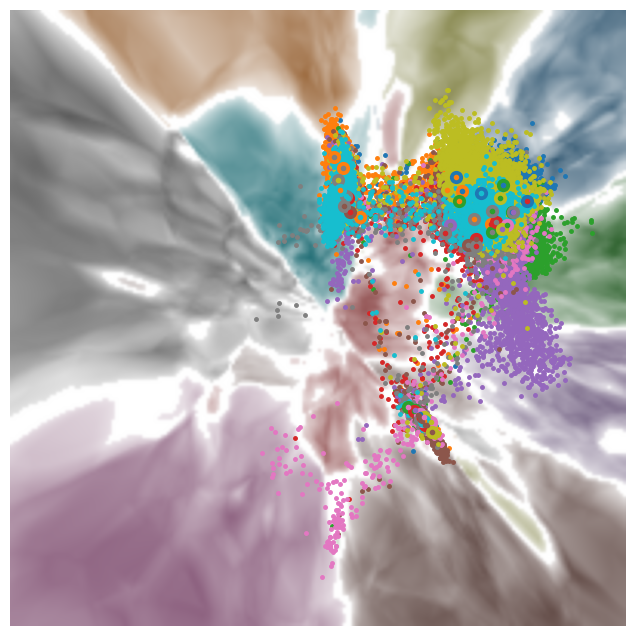

In [13]:
# checkpoint = torch.load("/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/cak_1v1.pth")
# autoencoder.load_state_dict(checkpoint['model_state_dict'])
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVisAutoEncoder.visualizer_ import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 4524.64it/s]


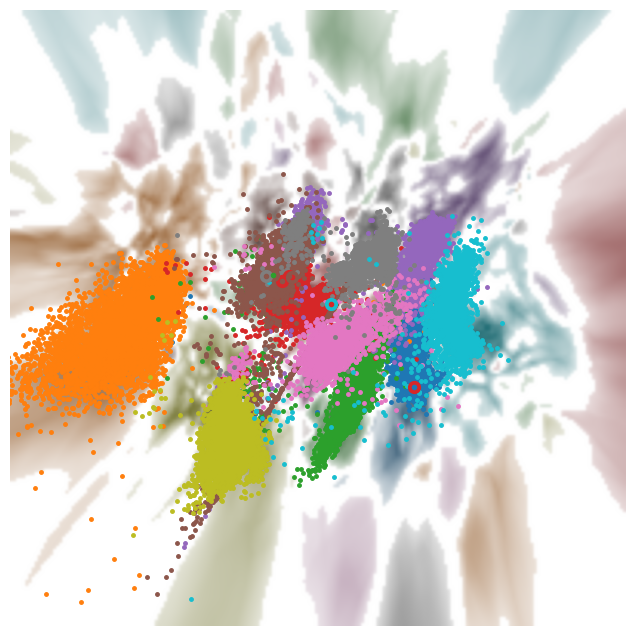

In [17]:
###### use auto encoder to visualize the prediction
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)
VIS_MODEL_NAME = 'baseline'
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVisAutoEncoder.visualizer_inv import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, tar_provider, autoencoder, np.dot(encoded_X.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 7735.31it/s]


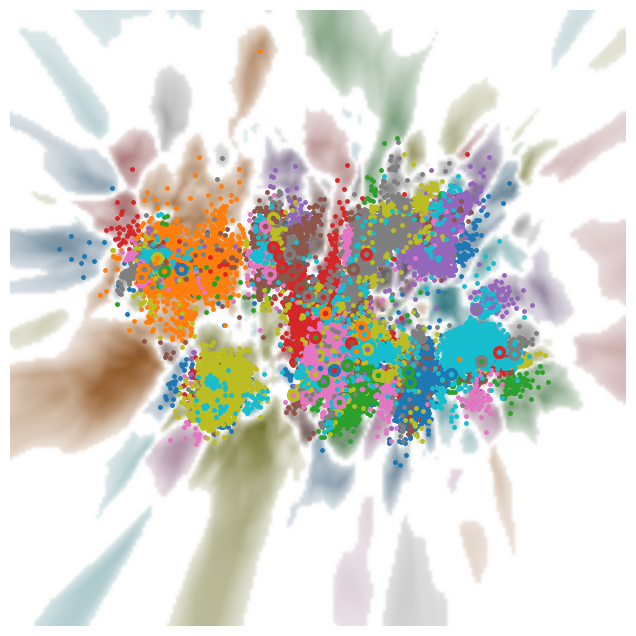

In [8]:


import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'baseline'
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
# from AlignVisAutoEncoder.visualizer_inv import visualizer
from representationTrans.trans_visualizer_border import visualizer
vis = visualizer(tar_provider, I,I, np.dot(tar_train_data, I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))